# 02 - Sentiment Analysis

In [1]:
import os
import pandas as pd
import numpy as np
import pickle
from collections import Counter, defaultdict
import re

# import sklearn models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from skmultilearn.problem_transform import LabelPowerset

# nlp libraries/api
import en_core_web_lg
from spacy import displacy
import gensim
from neuralcoref import Coref

spacy = en_core_web_lg.load()
coref = Coref(nlp=spacy)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


Loading neuralcoref model from /home/ubuntu/anaconda3/lib/python3.6/site-packages/neuralcoref/weights/
Loading embeddings from /home/ubuntu/anaconda3/lib/python3.6/site-packages/neuralcoref/weights/static_word
Loading embeddings from /home/ubuntu/anaconda3/lib/python3.6/site-packages/neuralcoref/weights/tuned_word


In [2]:
# Load opinion lexicon
neg_file = open("neg_words.txt",encoding = "ISO-8859-1")
pos_file = open("pos_words.txt",encoding = "ISO-8859-1")
neg = [line.strip() for line in neg_file.readlines()]
pos = [line.strip() for line in pos_file.readlines()]
opinion_words = neg + pos

# Uncomment below if running for first time. 
# Setup nltk corpora path and Google Word2Vec location
# google_vec_file = 'GoogleNews-vectors-negative300.bin'
# word2vec = gensim.models.KeyedVectors.load_word2vec_format(google_vec_file, binary=True)
# pickle.dump(word2vec, open("word2vec_google.pkl", 'wb'))

# If above script has been run, load saved word embedding
word2vec = pickle.load(open("word2vec_google.pkl", 'rb'))

# load the Multi-label binarizer from previous notebook
mlb = pickle.load(open("mlb.pkl", 'rb'))

# load the fitted naive bayes model from previous notebook
naive_model1 = pickle.load(open("naive_model1.pkl", 'rb'))

In [5]:
# uncomment to see the classes in multilabel binarizer used for the model
# mlb.classes_

In [55]:
# word embedding from word2vec will be used to supplement the naive bayes categorization
# of aspect terms. 
word2vec.n_similarity(['food'], ["sushi"])

0.4364909184729413

In [12]:
def check_similarity(aspects, word):
    similarity = []
    for aspect in aspects:
        similarity.append(word2vec.n_similarity([aspect], [word]))
    # set threshold for max value
    if max(similarity) > 0.30:
        return aspects[np.argmax(similarity)]
    else:
        return None

def assign_term_to_aspect(aspect_sent, terms_dict, sent_dict, pred):
    '''
    function: takes in a sentiment dictionary and appends the aspect dictionary
    inputs: sent_dict is a Counter in the form Counter(term:sentiment value)
            aspect_sent is total sentiment tally
            terms_dict is dict with individual aspect words associated with sentiment
    output: return two types of aspect dictionaries: 
            updated terms_dict and aspect_sent
    '''
    aspects = ['ambience', 'food', 'price', 'service']
    
    
    
    # First, check word2vec
    # Note: the .split() is used for the term because word2vec can't pass compound nouns
    for term in sent_dict:
        try:
            # The conditions for when to use the NB classifier as default vs word2vec
            if check_similarity(aspects, term.split()[-1]):
                terms_dict[check_similarity(aspects, term.split()[-1])][term] += sent_dict[term]
                if sent_dict[term] > 0:
                    aspect_sent[check_similarity(aspects, term.split()[-1])]["pos"] += sent_dict[term]
                else:
                    aspect_sent[check_similarity(aspects, term.split()[-1])]["neg"] += abs(sent_dict[term])
            elif (pred[0] == "anecdotes/miscellaneous"):
                continue
            elif (len(pred) == 1):
                terms_dict[pred[0]][term] += sent_dict[term]
                if sent_dict[term] > 0:
                    aspect_sent[pred[0]]["pos"] += sent_dict[term]
                else:
                    aspect_sent[pred[0]]["neg"] += abs(sent_dict[term])
            # if unable to classify via NB or word2vec, then put them in misc. bucket
            else:
                terms_dict["misc"][term] += sent_dict[term]
                if sent_dict[term] > 0:
                    aspect_sent["misc"]["pos"] += sent_dict[term]
                else:
                    aspect_sent["misc"]["neg"] += abs(sent_dict[term])
        except:
            print(term, "not in vocab")
            continue
    return aspect_sent, terms_dict
    
    
def feature_sentiment(sentence):
    '''
    input: dictionary and sentence
    function: appends dictionary with new features if the feature did not exist previously,
              then updates sentiment to each of the new or existing features
    output: updated dictionary
    '''

    sent_dict = Counter()
    sentence = spacy(sentence)
    debug = 0
    for token in sentence:
    #    print(token.text,token.dep_, token.head, token.head.dep_)
        # check if the word is an opinion word, then assign sentiment
        if token.text in opinion_words:
            sentiment = 1 if token.text in pos else -1
            # if target is an adverb modifier (i.e. pretty, highly, etc.)
            # but happens to be an opinion word, ignore and pass
            if (token.dep_ == "advmod"):
                continue
            elif (token.dep_ == "amod"):
                sent_dict[token.head.text] += sentiment
            # for opinion words that are adjectives, adverbs, verbs...
            else:
                for child in token.children:
                    # if there's a adj modifier (i.e. very, pretty, etc.) add more weight to sentiment
                    # This could be better updated for modifiers that either positively or negatively emphasize
                    if ((child.dep_ == "amod") or (child.dep_ == "advmod")) and (child.text in opinion_words):
                        sentiment *= 1.5
                    # check for negation words and flip the sign of sentiment
                    if child.dep_ == "neg":
                        sentiment *= -1
                for child in token.children:
                    # if verb, check if there's a direct object
                    if (token.pos_ == "VERB") & (child.dep_ == "dobj"):                        
                        sent_dict[child.text] += sentiment
                        # check for conjugates (a AND b), then add both to dictionary
                        subchildren = []
                        conj = 0
                        for subchild in child.children:
                            if subchild.text == "and":
                                conj=1
                            if (conj == 1) and (subchild.text != "and"):
                                subchildren.append(subchild.text)
                                conj = 0
                        for subchild in subchildren:
                            sent_dict[subchild] += sentiment

                # check for negation
                for child in token.head.children:
                    noun = ""
                    if ((child.dep_ == "amod") or (child.dep_ == "advmod")) and (child.text in opinion_words):
                        sentiment *= 1.5
                    # check for negation words and flip the sign of sentiment
                    if (child.dep_ == "neg"): 
                        sentiment *= -1
                
                # check for nouns
                for child in token.head.children:
                    noun = ""
                    if (child.pos_ == "NOUN") and (child.text not in sent_dict):
                        noun = child.text
                        # Check for compound nouns
                        for subchild in child.children:
                            if subchild.dep_ == "compound":
                                noun = subchild.text + " " + noun
                        sent_dict[noun] += sentiment
                    debug += 1
    return sent_dict

def classify_and_sent(sentence, aspect_sent, terms_dict):
    '''
    function: classify the sentence into a category, and assign sentiment
    note: aspect_dict is a parent dictionary with all the aspects
    input: sentence & aspect dictionary, which is going to be updated
    output: updated aspect dictionary
    '''
    # classify sentence with NB classifier
    predicted = naive_model1.predict([sentence])
    pred = mlb.inverse_transform(predicted)
    
    # get aspect names and their sentiment in a dictionary form
    sent_dict = feature_sentiment(sentence)
    
    # try to categorize the aspect names into the 4 aspects in aspect_dict
    aspect_sent, terms_dict = assign_term_to_aspect(aspect_sent, terms_dict, sent_dict, pred[0])
    return aspect_sent, terms_dict

def replace_pronouns(text):
    coref.one_shot_coref(text)
    return coref.get_resolved_utterances()[0]

def split_sentence(text):
    '''
    splits review into a list of sentences using spacy's sentence parser
    '''
    review = spacy(text)
    bag_sentence = []
    start = 0
    for token in review:
        if token.sent_start:
            bag_sentence.append(review[start:(token.i-1)])
            start = token.i
        if token.i == len(review)-1:
            bag_sentence.append(review[start:(token.i+1)])
    return bag_sentence

# Remove special characters using regex
def remove_special_char(sentence):
    return re.sub(r"[^a-zA-Z0-9.',:;?]+", ' ', sentence)

def review_pipe(review, aspect_sent, terms_dict={'ambience':Counter(), 'food':Counter(), 'price':Counter(), 'service':Counter(),'misc':Counter()}):
    review = replace_pronouns(review)
    sentences = split_sentence(review)
    for sentence in sentences:
        sentence = remove_special_char(str(sentence))
        aspect_sent, terms_dict = classify_and_sent(sentence.lower(), aspect_sent, terms_dict)
    return aspect_sent, terms_dict

In [4]:
# test code for feature sentiment
sentence= "I came here with my friends on a Tuesday night. The sushi here is amazing. Our waiter was very helpful, but the music was terrible."
feature_sentiment(sentence)

# uncomment to visualize dependency words via spaCy's displacy feature
# displacy.render(spacy(sentence), style='dep',jupyter=True)

Counter({'sushi': 1, 'waiter': 1, 'music': -1})

In [148]:
# test code for special char function
# remove_special_char("he's/a")

"he's a"

In [59]:
# test code
# aspect_dict={'ambience':Counter(), 'food':Counter(), 'price':Counter(), 'service':Counter(),'misc':Counter()}
# classify_and_sent("ambience was great, but the bar waiter was bad. However, the music was good.", aspect_dict)

In [16]:
# test code
terms_dict={'ambience':Counter(), 'food':Counter(), 'price':Counter(), 'service':Counter(),'misc':Counter()}
aspect_sent={'ambience':Counter(), 'food':Counter(), 'price':Counter(), 'service':Counter(),'misc':Counter()}
review = "Our waiter was not very helpful, and the music was terrible."
test1, test2 = review_pipe(review, aspect_sent, terms_dict)

In [17]:
test1, test2

({'ambience': Counter({'neg': 1}),
  'food': Counter(),
  'price': Counter(),
  'service': Counter({'neg': 1}),
  'misc': Counter()},
 {'ambience': Counter({'music': -1}),
  'food': Counter(),
  'price': Counter(),
  'service': Counter({'waiter': -1}),
  'misc': Counter()})

In [151]:
test1={'ambience':Counter(), 'food':Counter(), 'price':Counter(), 'service':Counter(),'misc':Counter()}
test2={'ambience':Counter(), 'food':Counter(), 'price':Counter(), 'service':Counter(),'misc':Counter()}
review = "top notch"
review_pipe(review, test1, test2)

({'ambience': Counter(),
  'food': Counter(),
  'price': Counter(),
  'service': Counter({'pos': 1}),
  'misc': Counter()},
 {'ambience': Counter(),
  'food': Counter(),
  'price': Counter(),
  'service': Counter({'notch': 1}),
  'misc': Counter()})

## Pipeline:  
for each review:  
1) replace pronouns using neural coref api  
2) split each review into sentences  
3) update aspect dictionary

In [82]:
for key in a:
    if a[key]:
        print(str(key), ":", a[key])

ambience : Counter({'ambience': 1})
service : Counter({'bar waiter': -1})


# Load up dataframe and test

In [9]:
pitt = pd.read_pickle("yelp_pitt.pkl")
pitt = pitt.drop(["neighborhood","address","city","state",
                        "postal_code","latitude","longitude"],1)
meat_potatoes = pitt[pitt.name=='"Meat & Potatoes"']

In [59]:
# There are two restaurants named primanti on yelp. Query one of the restaurants 
# that has 1101 reviews.
primanti = pitt[(pitt.name == '"Primanti Bros."') & (pitt.review_count == 1101)]

# below is an output for a restaurant called church brew. You could filter for 
# any of the restaurants of interest by modifying the code above for primanti restaurant
#church_brew.head()

,business_id,name,stars,review_count,is_open,categories,review_id,date,text
60854,ejaUQ1hYo7Q7xCL1HdPINw,"""Church Brew Works""",3.5,902,1,Food;Bars;Restaurants;Nightlife;American (Trad...,auuK-22bRD2Dof-Id_yARQ,2007-09-11,I have only eaten here once. I loved it. I h...
60855,ejaUQ1hYo7Q7xCL1HdPINw,"""Church Brew Works""",3.5,902,1,Food;Bars;Restaurants;Nightlife;American (Trad...,roxkoo8--Xzx7cEyTsa6Sg,2015-09-19,This place is pretty great. Cool atmosphere an...
60856,ejaUQ1hYo7Q7xCL1HdPINw,"""Church Brew Works""",3.5,902,1,Food;Bars;Restaurants;Nightlife;American (Trad...,XC-2EQth8nIGlSjhhUUz8w,2015-01-05,this place.\n\nthis place is just.. well its ...
60857,ejaUQ1hYo7Q7xCL1HdPINw,"""Church Brew Works""",3.5,902,1,Food;Bars;Restaurants;Nightlife;American (Trad...,6EbU6g6UKqUoHtrMu54mCA,2015-07-07,Church Brew Works is one of my favorite destin...
60858,ejaUQ1hYo7Q7xCL1HdPINw,"""Church Brew Works""",3.5,902,1,Food;Bars;Restaurants;Nightlife;American (Trad...,W47xzTcOtp4iCw7zBj5lvA,2013-08-29,"So, my review is not really indicative of the ..."


In [44]:
pitt[(pitt.name!='"Meat & Potatoes"') & (pitt.categories.str.contains(";American"))].sort_values("review_count",ascending=False)

,business_id,name,stars,review_count,is_open,categories,review_id,date,text
21237,lKom12WnYEjH5FFemK3M1Q,"""Primanti Bros.""",3.5,1101,1,Nightlife;American (New);Bars;Sports Bars;Sand...,oudvphYKHoRN5azxsTp9kw,2013-05-15,The sandwich was great! I was visiting Pittsb...
20506,lKom12WnYEjH5FFemK3M1Q,"""Primanti Bros.""",3.5,1101,1,Nightlife;American (New);Bars;Sports Bars;Sand...,KMrtQWhFHWW-YXO_vrc38Q,2015-10-14,"On our way home from Canada, we decided to cut..."
20500,lKom12WnYEjH5FFemK3M1Q,"""Primanti Bros.""",3.5,1101,1,Nightlife;American (New);Bars;Sports Bars;Sand...,JaD111dCJgwJNdZj1aHXzg,2012-09-02,"Sorry Pittsburgh, I don't get it. After a long..."
20501,lKom12WnYEjH5FFemK3M1Q,"""Primanti Bros.""",3.5,1101,1,Nightlife;American (New);Bars;Sports Bars;Sand...,308tpcJA4QmV19HcewFfUw,2016-01-13,Can't imagine how they ruined Mancini's bread?...
20502,lKom12WnYEjH5FFemK3M1Q,"""Primanti Bros.""",3.5,1101,1,Nightlife;American (New);Bars;Sports Bars;Sand...,4Isset7d6m_2F_1fupeNZQ,2006-12-19,I was born & raised in Pittsburgh & when I fin...
20503,lKom12WnYEjH5FFemK3M1Q,"""Primanti Bros.""",3.5,1101,1,Nightlife;American (New);Bars;Sports Bars;Sand...,LPtfQsZbiNl22Q1ru7_x5g,2014-01-27,Eating Primanti Brothers food is like taking t...
20504,lKom12WnYEjH5FFemK3M1Q,"""Primanti Bros.""",3.5,1101,1,Nightlife;American (New);Bars;Sports Bars;Sand...,h3vHqmyaMRcsBUgXRGHuNQ,2012-08-10,"I hate Shitsburgh, but this place does it righ..."
20505,lKom12WnYEjH5FFemK3M1Q,"""Primanti Bros.""",3.5,1101,1,Nightlife;American (New);Bars;Sports Bars;Sand...,_n9Z-X6aqZ_jyJOmbW3_eA,2014-05-28,This is the original location. And the best. I...
20507,lKom12WnYEjH5FFemK3M1Q,"""Primanti Bros.""",3.5,1101,1,Nightlife;American (New);Bars;Sports Bars;Sand...,TDlSwIKsyr-ckARAQvsQMA,2010-07-19,So I found this place on the Food Network. My...
20481,lKom12WnYEjH5FFemK3M1Q,"""Primanti Bros.""",3.5,1101,1,Nightlife;American (New);Bars;Sports Bars;Sand...,bY8WxsoiITGsUVp2C4lymw,2016-07-29,After hearing and reading all the hype I was u...


In [53]:
len(primanti)

1101

In [54]:
terms_dict={'ambience':Counter(), 'food':Counter(), 'price':Counter(), 'service':Counter(),'misc':Counter()}
aspect_sent={'ambience':Counter(), 'food':Counter(), 'price':Counter(), 'service':Counter(),'misc':Counter()}
# modify for each restaurant
for review in primanti.text:
    aspect_sent, terms_dict = review_pipe(review, aspect_sent, terms_dict)

primanti not in vocab
primanti not in vocab
primantis not in vocab
pittsburgher not in vocab
primanti not in vocab
pittsburg not in vocab
a not in vocab
primantis not in vocab
primanti not in vocab
primantis not in vocab
pittsburger not in vocab
pittsburger not in vocab
kolbassi not in vocab
calslaw not in vocab
love primanti not in vocab
primanti not in vocab
primanti not in vocab
primanti not in vocab
primanti not in vocab
primanti not in vocab
speciality not in vocab
pittsburger not in vocab
myron not in vocab
resteraunt not in vocab
a not in vocab
chresesteak not in vocab
beef primanti not in vocab
sandwichs not in vocab
primantis not in vocab
pittsburger not in vocab
primanti not in vocab
primanti not in vocab
primanti not in vocab
shitsburgh not in vocab
primantis not in vocab
primanti not in vocab
primanti not in vocab
samiches not in vocab
primanti not in vocab
permanti not in vocab
primanti not in vocab
4stars not in vocab
primanti not in vocab
yeungling not in vocab
people'd 

In [56]:
# final output aspect sentiment, which is the overall sentiment scores
aspect_sent

{'ambience': Counter({'pos': 282.0, 'neg': 122.5}),
 'food': Counter({'pos': 2112.25, 'neg': 1033.5}),
 'price': Counter({'neg': 22, 'pos': 109.5}),
 'service': Counter({'neg': 213.0, 'pos': 309.5}),
 'misc': Counter({'pos': 25.0, 'neg': 11.25})}

In [42]:
# final output all the aspect terms
primanti_terms

{'ambience': Counter({'feelings': -1,
          'back': -1,
          'mood': 0,
          'spicy': 1,
          'attitude': -2,
          'district location': 1,
          'charm': 10.5,
          'noise': -4,
          'ranch flavor': 1.5,
          'location': 37.0,
          'clean': 1,
          'staff': 1,
          'atmosphere': 61.5,
          'interior': -1.5,
          'lights': 1,
          'type': -3,
          'environment': 1,
          'soccer fans': 1,
          'ambiance': 4.5,
          'music': -1,
          'harmarville location': -1.5,
          'quality': 5,
          'greasiness': 1,
          'part': 1,
          'experience': 2,
          'flavor': 4.5,
          'street location': -1.5,
          'side': -2,
          'sign': -1,
          'spot': 4,
          'building': -1,
          'impression': -1,
          'decadent': -1,
          'cuisines': 1,
          'taste': 2.5,
          'what': 0,
          'flight': -1,
          'basement': -1,
          'pr

In [57]:
# pickle the aspect terms and sentiment separately.
# Modify this code for the restaurant of interest.
pickle.dump(aspect_sent, open("primanti_sentiment.pkl", 'wb'))
pickle.dump(terms_dict, open("primanti_dict.pkl", 'wb'))

In [35]:
primanti_sent = pickle.load(open("primanti_sentiment.pkl", 'rb'))
primanti_terms = pickle.load(open("primanti_dict.pkl", 'rb'))
meat_potatoes_sent = pickle.load(open("meat_potatoes_sentiment.pkl", 'rb'))
meat_potatoes_terms = pickle.load(open("meat_potatoes_dict.pkl", 'rb'))

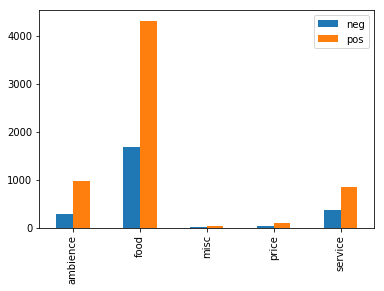

In [24]:
import matplotlib.pyplot as plt

# quick visualization
pd.DataFrame(meat_potatoes_sent).T.plot(kind='bar')
plt.show()

Now that we have pickled files, we can generate visualizations using plotly in the 3rd notebook 03.